In [1]:
from datasets import load_dataset

In [2]:
import pandas as pd

### Load the dataset

In [3]:
dataset = load_dataset("yelp_review_full")

Found cached dataset yelp_review_full (/Users/jhuguet/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf)


  0%|          | 0/2 [00:00<?, ?it/s]

### Convert it to pandas a random sample of 1000 articles

In [4]:
df = pd.DataFrame(dataset["train"].shuffle(42).select(range(1000)))

Loading cached shuffled indices for dataset at /Users/jhuguet/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf/cache-a0e621c27d9b360e.arrow


## Embedd sentences

In [5]:
from sentence_transformers import SentenceTransformer

In [6]:
model = SentenceTransformer("distiluse-base-multilingual-cased-v2")

In [7]:
sentence_embedding = model.encode("This is a sentence about cats")

In [8]:
sentence_embedding.shape

(512,)

## Get sentence embeddings for all texts

In [9]:
from tqdm import tqdm
tqdm.pandas()

In [10]:
df["embedding"] = df["text"].progress_apply(model.encode)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:31<00:00, 31.56it/s]


## Let's reduce the dimensionality and visualize the data in 2d

In [11]:
import umap

/Users/jhuguet/Library/Caches/pypoetry/virtualenvs/nlp-workshop-pVJHvytM-py3.9/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/jhuguet/Library/Caches/pypoetry/virtualenvs/nlp-workshop-pVJHvytM-py3.9/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.

In [12]:
def reduce_dimensions(embeddings,
                      n_components=2,
                      n_neighbors=8,
                      random_state = 42):
    
    umap_embeddings = (umap.UMAP(n_neighbors=n_neighbors, 
                                n_components=n_components, 
                                metric='cosine',
                                 n_epochs=1000,
                                random_state=random_state)
                            .fit_transform(embeddings))
    df = pd.DataFrame(umap_embeddings, index=embeddings.index)
    return df

In [13]:
embeddings = df["embedding"].apply(pd.Series)

In [14]:
embeddings_2d = reduce_dimensions(embeddings)

In [15]:
embeddings_2d

,0,1
0,9.829710,8.267928
1,6.893500,11.057710
2,9.842501,5.955735
3,11.369548,8.424397
4,8.609755,11.211648
...,...,...
995,9.233823,8.775332
996,6.731916,7.434376
997,8.184518,10.360422
998,6.435501,9.319263


### Let's visualize them...

In [16]:
import seaborn as sns

<Axes: xlabel='0', ylabel='1'>

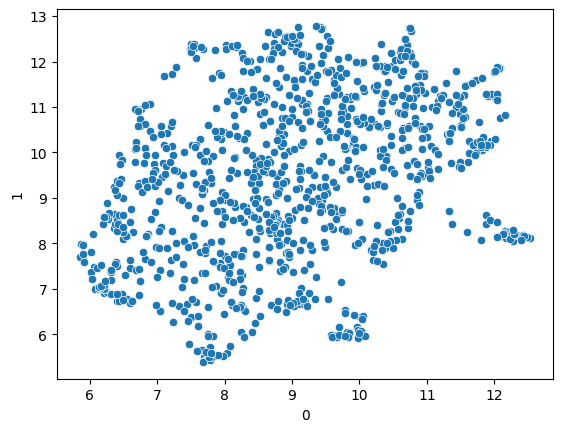

In [17]:
sns.scatterplot(embeddings_2d, x=0, y=1)

Nice, let's see if we can cluster them....

In [18]:
from sklearn.cluster import AgglomerativeClustering

In [19]:
clst = AgglomerativeClustering(n_clusters=10)

In [20]:
clusters = clst.fit_predict(embeddings)

## Let's assign the clusters to the visualization

<Axes: xlabel='0', ylabel='1'>

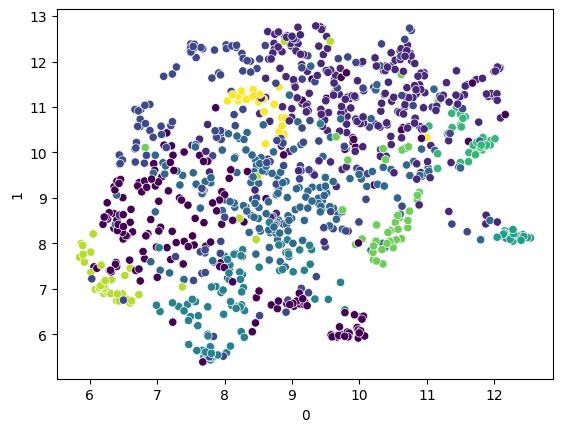

In [21]:
sns.scatterplot(embeddings_2d, x=0, y=1, c=clusters)

## Now, let's review the contents of the clusters...

In [22]:
df["cluster"] = clusters

In [23]:
df.sort_values(by="cluster")

,label,text,embedding,cluster
0,4,I stalk this truck. I've been to industrial p...,"[-0.064660534, 0.028532796, 0.023364373, -0.00...",0
241,3,I go out of my way to find a Fry's. Great cust...,"[0.049941614, 0.0074083344, 0.008650541, 0.018...",0
489,3,One of my new favourite shawarma places (and p...,"[0.00834208, -0.015408866, 0.027177632, -0.013...",0
246,1,Another new name but the same overpriced stuff...,"[0.0051886197, 0.03574604, 0.022532156, -0.042...",0
748,1,"I don't do dollar stores often, but I thought ...","[0.029022584, 0.04669228, 0.032092497, -0.0173...",0
...,...,...,...,...
310,1,"My wife absolutely loved her turkey burger, an...","[-0.015072696, 0.032361403, 0.015344034, 0.017...",9
769,4,The burger was excellent. Ordered to go at the...,"[-0.027631082, -0.020660503, 0.052475438, -0.0...",9
287,1,I guess I really just dont like buffets in thi...,"[-0.00534139, 0.077118464, 0.017128773, 0.0066...",9
76,0,Seemingly popular with the 20-somethings with ...,"[-0.0055780075, 0.0068209902, 0.004916317, -0....",9


In [25]:
df.loc[df["cluster"] == 9, "text"]

24     Food was disappointing and ridiculously overpr...
54     The side of sauteed Spinach was incredibly sal...
76     Seemingly popular with the 20-somethings with ...
143    It wasn't horrible and it wasn't mind-blowing....
176    I though it was overpriced, the steak was good...
235    I like a menu that has limited choices. Howeve...
272    One of the best if not the best ever Bone In R...
287    I guess I really just dont like buffets in thi...
288    It's OK, I'm not going to go out of my way rav...
310    My wife absolutely loved her turkey burger, an...
390    A little overpriced for the quality. The filet...
419    We stopped for dinner want to have a steak.  T...
444    I first heard about this place when I saw Hube...
463    I thought the steak needed more flavor.   It w...
486    This is a great old steakhouse.  The steak was...
520    This place is awesome. Tasty burgers and fresh...
586    Just as the title implies the burgers are flam...
665    So I decided to bring a 